In [13]:
import os
from os import path
from astropy.io import fits
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.wcs import WCS
from copy import deepcopy
from calibrimbore.bill import get_skymapper_region
%matplotlib widget

In [44]:
hdul = fits.open('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')
wcs = WCS('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')

hdul = fits.open('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')
wcs = WCS('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [45]:
wcs = WCS(hdul[1].header)
data = hdul[1].data

In [46]:
ra,dec, lam = wcs.all_pix2world(data.shape[2]/2,data.shape[1]/2,100,0)

In [70]:
#cat = get_skymapper_region([ra],[dec],size=100)
cat = get_gaia_region([ra],[dec],size=50)

In [71]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)

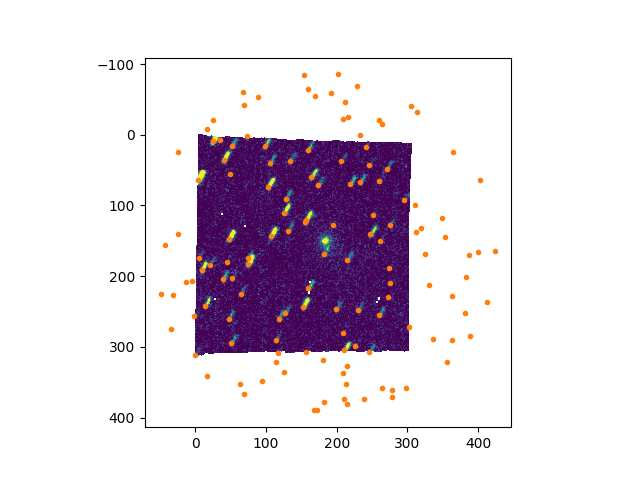

In [76]:
plt.figure()
plt.imshow(data[100],vmin=0,vmax=100)
plt.plot(x+22,y,'C1.')

In [78]:
cat.keys()

Index(['_q', 'ra', 'e_RA_ICRS', 'dec', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx',
       'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG', 'Gmag',
       'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP', 'RPmag',
       'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_', 'Rad',
       'Lum'],
      dtype='object')

In [79]:
cat['Teff']

0         NaN
1      5324.5
2         NaN
3         NaN
4         NaN
        ...  
130       NaN
131       NaN
132       NaN
133       NaN
134       NaN
Name: Teff, Length: 135, dtype: float64

In [62]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from astroquery.vizier import Vizier

def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 21):
	"""
	Get the coordinates and mag of all gaia sources in the field of view.

	-------
	Inputs-
	-------
		tpf 				class 	target pixel file lightkurve class
		magnitude_limit 	float 	cutoff for Gaia sources
		Offset 				int 	offset for the boundary 
	
	--------
	Outputs-
	--------
		coords 	array	coordinates of sources
		Gmag 	array 	Gmags of sources
	"""
	c1 = SkyCoord(ra, dec, unit='deg')
	Vizier.ROW_LIMIT = -1

	result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                             		 radius=Angle(size, "arcsec"),column_filters={'Gmag':f'<{magnitude_limit}'})

	keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
			'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
			'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
			'row','col']


	no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
	if result is None:
		raise no_targets_found_message
	elif len(result) == 0:
		raise no_targets_found_message
	

	result = result['I/345/gaia2'].to_pandas()
	result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
	return result



In [80]:
c1 = SkyCoord(ra, dec, unit='deg')
Vizier.ROW_LIMIT = -1

result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                                    radius=Angle(50, "arcsec"),column_filters={'Gmag':f'<{23}'})


In [81]:
result

TableList with 1 tables:
	'0:I/355/gaiadr3' with 57 column(s) and 139 row(s) 